In [234]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.pyplot import xticks
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

## Data load

In [2]:
df = pd.read_csv('data/df_out.csv')
print(df.shape)
df.head(5)

(10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


## Data Preparation

### Data cleaning

In [3]:
print('Информация о выборке:\n')
df.info()

Информация о выборке:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_d

In [4]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()

print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


id                0.00
state             0.00
price_category    0.00
manufacturer      0.00
odometer          0.00
region_url        0.00
region            0.00
url               0.00
price             0.00
image_url         0.02
description       0.02
posting_date      0.02
date              0.02
year              0.36
transmission      0.45
fuel              0.63
lat               0.98
long              0.98
model             1.28
title_status      1.66
dtype: float64

In [5]:
# список всех признаков, в которых имеются пропущенные значения 
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()
missing_columns = missing_values[missing_values.values > 0].index.tolist()
print('список всех признаков, в которых имеются пропущенные значения \n', missing_columns)

список всех признаков, в которых имеются пропущенные значения 
 ['image_url', 'description', 'posting_date', 'date', 'year', 'transmission', 'fuel', 'lat', 'long', 'model', 'title_status']


#### Обработка пропусков в годе выпуска автомобиля

In [6]:
# количество пустых значении в поле год
df.year.isna().sum() 

36

In [7]:
#описательная статистика признака год выпуска автомобиля
df.year.describe() 

count    9964.000000
mean     2010.927941
std         9.672040
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [8]:
# записи в которых год выпуска не заполнен
df[df['year'].isna()] 

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
344,7304102133,https://wenatchee.craigslist.org/ctd/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,35880,NaN,other,500,gas,13508,clean,automatic,https://images.craigslist.org/00J0J_6IMoEUzIIM...,2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...,wa,47.434493,-120.320759,2021-04-09T06:31:03-0700,high,2021-04-09 13:31:03+00:00
420,7316337069,https://lasvegas.craigslist.org/ctd/d/scottsda...,las vegas,https://lasvegas.craigslist.org,84995,NaN,other,Super Duty F-350 SRW,diesel,1268,clean,automatic,https://images.craigslist.org/00x0x_iQCC0Ef28S...,2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...,nv,33.458277,-111.925970,2021-05-03T11:31:39-0700,high,2021-05-03 18:31:39+00:00
425,7315662117,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,43900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00f0f_7AwipNocNH...,"2019 *Dodge* *Grand Caravan* SE - $43,900Call ...",co,39.674406,-104.998604,2021-05-02T01:11:33-0600,high,2021-05-02 07:11:33+00:00
702,7316199009,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,28498,NaN,other,olet Silverado 1500,NaN,59246,NaN,automatic,https://images.craigslist.org/00T0T_dZ7nOXskCS...,2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...,tn,36.138022,-86.732261,2021-05-03T10:00:40-0500,high,2021-05-03 15:00:40+00:00
893,7316840794,https://denver.craigslist.org/ctd/d/american-f...,denver,https://denver.craigslist.org,60900,NaN,other,F-150,gas,6110,clean,automatic,https://images.craigslist.org/01616_bpzSdSRTbx...,"2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...",co,40.362248,-111.785947,2021-05-04T12:11:22-0600,high,2021-05-04 18:11:22+00:00
906,7311915616,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,67900,NaN,other,Odyssey,gas,21,clean,automatic,https://images.craigslist.org/00404_erlbeKWEkn...,2020 *Honda* *Odyssey* EX-L w/Navi/RES Automat...,co,39.674406,-104.998604,2021-04-24T10:41:06-0600,high,2021-04-24 16:41:06+00:00
1005,7306735187,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,38900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00F0F_3T6FM0XMZW...,"2019 *Dodge* *Grand Caravan* SE - $38,900Call ...",co,39.674406,-104.998604,2021-04-14T10:51:36-0600,high,2021-04-14 16:51:36+00:00
1217,7309954650,https://gainesville.craigslist.org/ctd/d/gaine...,gainesville,https://gainesville.craigslist.org,24975,NaN,other,CR-V,gas,44128,clean,automatic,https://images.craigslist.org/00000_2TUtAgLlCR...,"2019 *Honda* *CR-V* EX 2WD SUV - $24,975Call o...",fl,29.676827,-82.319202,2021-04-20T14:46:55-0400,high,2021-04-20 18:46:55+00:00
1319,7313865045,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,47900,NaN,other,a Sienna,gas,43701,clean,automatic,https://images.craigslist.org/00o0o_8XYp4Zygdj...,2018 *Toyota* *Sienna* LE Automatic Access Sea...,co,39.674406,-104.998604,2021-04-28T10:12:14-0600,high,2021-04-28 16:12:14+00:00
1845,7303344554,https://daytona.craigslist.org/ctd/d/new-smyrn...,daytona beach,https://daytona.craigslist.org,35850,NaN,other,Transit Cargo Van,gas,567,clean,automatic,https://images.craigslist.org/00a0a_d4XVrHnlxl...,"2020 *Ford* *Transit Cargo Van* T-250 148"" WB*...",fl,29.046240,-80.934561,2021-04-07T17:10:06-0400,high,2021-04-07 21:10:06+00:00


Если посмотреть на данные то можно увидеть что у большинства записей год выпуска указан в признаке описание. Но лучше удалить записи с пустым значением года выпуска автомобиля.

In [9]:
# создаем копию датасета и удаляем записи, в которых год выпуска автомобиля не заполнен. Размер датасета меняется
df = df.copy()
df_year = df.dropna(subset=['year'])
df_year.shape

(9964, 20)

In [10]:
# проверяем количество пропущенных значений в годе выпуска автомобиля для обновлённого датафрейма.
print("Количество пропущенных значений в year:", df_year['year'].isna().sum())

Количество пропущенных значений в year: 0


#### Обработка пропусков в типе топлива

In [11]:
# количество значений для типа топлива
df_year['fuel'].value_counts(dropna=False) 

fuel
gas         8379
other        729
diesel       650
hybrid       108
NaN           54
electric      44
Name: count, dtype: int64

54 значении не заполнены

In [12]:
# записи, в которых тип топлива не заполнен
df_year[df_year['fuel'].isna()] 

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
32,7309910590,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,4977,2001.0,toyota,camry solara 2dr cpe se v6 auto (natl),NaN,193242,clean,automatic,https://images.craigslist.org/00F0F_ebtJlxCQjv...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-04-20T10:40:15-0700,low,2021-04-20 17:40:15+00:00
78,7314559074,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,27977,2009.0,ford,"f-150 4wd supercrew 145"" platinum",NaN,79522,clean,automatic,https://images.craigslist.org/00L0L_khoMmqXaSJ...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-04-29T15:15:30-0700,high,2021-04-29 22:15:30+00:00
275,7315141987,https://honolulu.craigslist.org/oah/ctd/d/fort...,hawaii,https://honolulu.craigslist.org,29888,2019.0,nissan,frontier crew cab 4x2 sv auto,NaN,10679,clean,automatic,https://images.craigslist.org/00F0F_d9wEXQuSyu...,***Call Us for more information at: 877-262-34...,hi,21.344376,-157.896975,2021-04-30T15:50:19-1000,high,2021-05-01 01:50:19+00:00
471,7316807613,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,13436,2006.0,chevrolet,"silverado 1500 ext cab 143.5"" wb 4wd ls",NaN,172700,clean,automatic,https://images.craigslist.org/00l0l_35tV0gQdD8...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-05-04T10:20:19-0700,medium,2021-05-04 17:20:19+00:00
1009,7314561306,https://cnj.craigslist.org/ctd/d/parlin-2000-c...,central NJ,https://cnj.craigslist.org,5894,2000.0,chevrolet,"s-10 ext cab 123"" wb ls",NaN,78740,clean,automatic,https://images.craigslist.org/00O0O_8vd70bT1rY...,***Call Us for more information at: 732-316-55...,nj,40.468650,-74.296990,2021-04-29T18:20:19-0400,low,2021-04-29 22:20:19+00:00
1279,7310297136,https://westernmass.craigslist.org/ctd/d/johns...,western massachusetts,https://westernmass.craigslist.org,6000,2008.0,other,IC IC,NaN,0,NaN,automatic,https://images.craigslist.org/00404_cBFpBKbfr2...,"2008 *IC* *IC* CE300 - $6,000Call Us Today! 85...",ma,43.008105,-74.352011,2021-04-21T10:11:05-0400,low,2021-04-21 14:11:05+00:00
1318,7310414739,https://nwct.craigslist.org/ctd/d/melville-200...,northwest CT,https://nwct.craigslist.org,11995,2007.0,gmc,c-7500 multiple uses perfect,NaN,50098,clean,automatic,https://images.craigslist.org/00T0T_jvsOAKSGAr...,2007 *GMC* *C-7500 MULTIPLE USES PERFECT* FOR ...,ct,40.681179,-73.430488,2021-04-21T13:18:41-0400,medium,2021-04-21 17:18:41+00:00
1686,7316342709,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,19942,2017.0,ram,"promaster cargo van 1500 low roof 118"" wb",NaN,88836,clean,automatic,https://images.craigslist.org/00707_6ZlIIpYmGf...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T14:40:24-0400,medium,2021-05-03 18:40:24+00:00
1847,7315151536,https://honolulu.craigslist.org/oah/ctd/d/fort...,hawaii,https://honolulu.craigslist.org,29988,2019.0,toyota,sienna le fwd 8-passenger (natl),NaN,18762,clean,automatic,https://images.craigslist.org/00R0R_dO0gtiRwLa...,***Call Us for more information at: 877-262-34...,hi,21.344376,-157.896975,2021-04-30T16:25:22-1000,high,2021-05-01 02:25:22+00:00


In [13]:
# обрабатываем пропущенные записи заполнив их значением other
df_year['fuel'] = df_year['fuel'].fillna('other') 

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\2133168483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['fuel'] = df_year['fuel'].fillna('other')


In [14]:
# проверяем количество пропущенных значений в виде топлива.
print("Количество пропущенных значений в fuel:", df_year['fuel'].isna().sum()) 

Количество пропущенных значений в fuel: 0


In [15]:
# Повторная проверка пропущенных значении в обновленном датафрейме
missing_values = ((df_year.isna().sum() / len(df_year)) * 100).sort_values()
missing_columns = missing_values[missing_values.values > 0].index.tolist()
print('список всех признаков, в которых имеются пропущенные значения \n', missing_columns)

список всех признаков, в которых имеются пропущенные значения 
 ['transmission', 'lat', 'long', 'model', 'title_status']


In [16]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9964 non-null   int64  
 1   url             9964 non-null   object 
 2   region          9964 non-null   object 
 3   region_url      9964 non-null   object 
 4   price           9964 non-null   int64  
 5   year            9964 non-null   float64
 6   manufacturer    9964 non-null   object 
 7   model           9838 non-null   object 
 8   fuel            9964 non-null   object 
 9   odometer        9964 non-null   int64  
 10  title_status    9805 non-null   object 
 11  transmission    9921 non-null   object 
 12  image_url       9964 non-null   object 
 13  description     9964 non-null   object 
 14  state           9964 non-null   object 
 15  lat             9868 non-null   float64
 16  long            9868 non-null   float64
 17  posting_date    9964 non-null   object

#### Обработка пропусков в коробкe передач

In [17]:
# количество значений для коробкe передач
df_year['transmission'].value_counts(dropna=False) 

transmission
automatic    7667
other        1623
manual        631
NaN            43
Name: count, dtype: int64

43 пустых значении

In [18]:
# записи, в которых тип коробки передач не заполнен
df_year[df_year['transmission'].isna()] 

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
111,7305109580,https://grandrapids.craigslist.org/ctd/d/comst...,grand rapids,https://grandrapids.craigslist.org,12750,2013.0,lexus,es,gas,109382,clean,NaN,https://images.craigslist.org/00n0n_kACT1l7OCN...,2013 Lexus ES 350 4dr Sdn Offered by: Auto...,mi,43.059210,-85.688970,2021-04-11T09:41:58-0400,medium,2021-04-11 13:41:58+00:00
112,7314951119,https://southjersey.craigslist.org/ctd/d/chest...,south jersey,https://southjersey.craigslist.org,18199,2012.0,jeep,wrangler,other,130174,clean,NaN,https://images.craigslist.org/00I0I_gRmuXmqil1...,2012 Jeep Wrangler Unlimited Sport 4WD Off...,nj,40.135190,-74.703570,2021-04-30T14:58:56-0400,medium,2021-04-30 18:58:56+00:00
817,7308021604,https://southjersey.craigslist.org/ctd/d/maple...,south jersey,https://southjersey.craigslist.org,11999,2015.0,honda,civic,gas,79797,clean,NaN,https://images.craigslist.org/00b0b_aCqgRZ7sAx...,2015 Honda Civic EX Offered by: VIP Auto O...,nj,39.938023,-74.971461,2021-04-16T19:46:55-0400,medium,2021-04-16 23:46:55+00:00
931,7314781483,https://nh.craigslist.org/ctd/d/plaistow-2018-...,new hampshire,https://nh.craigslist.org,64990,2018.0,ram,3500,other,8853,clean,NaN,https://images.craigslist.org/00000_iHpXs2BVmN...,2018 RAM Ram Chassis 3500 Short Wheelbase (Dua...,nh,42.834977,-71.107791,2021-04-30T10:15:30-0400,high,2021-04-30 14:15:30+00:00
970,7315044723,https://poconos.craigslist.org/ctd/d/chesterfi...,poconos,https://poconos.craigslist.org,22699,2014.0,jeep,wrangler,gas,110493,clean,NaN,https://images.craigslist.org/00M0M_aFDXWIfug9...,2014 Jeep Wrangler Unlimited Sport 4WD Off...,pa,40.135190,-74.703570,2021-04-30T17:46:04-0400,high,2021-04-30 21:46:04+00:00
1156,7311083008,https://greenville.craigslist.org/ctd/d/greenv...,greenville / upstate,https://greenville.craigslist.org,9998,2013.0,volkswagen,jetta,diesel,96115,clean,NaN,https://images.craigslist.org/00F0F_9oq0KNmZIM...,2013 VOLKSWAGEN JETTA TDI Highline Offered...,sc,34.832550,-82.368350,2021-04-22T17:55:57-0400,medium,2021-04-22 21:55:57+00:00
1349,7303942891,https://wenatchee.craigslist.org/ctd/d/everett...,wenatchee,https://wenatchee.craigslist.org,4995,2005.0,honda,pilot,gas,261591,clean,NaN,https://images.craigslist.org/00S0S_aASnH27HDH...,2005 Honda Pilot EX Offered by: Corn Motor...,wa,47.912956,-122.235725,2021-04-08T16:52:48-0700,low,2021-04-08 23:52:48+00:00
1715,7310344536,https://roanoke.craigslist.org/ctd/d/roanoke-2...,roanoke,https://roanoke.craigslist.org,3995,2007.0,ford,mustang,gas,159342,clean,NaN,https://images.craigslist.org/00J0J_6BuTyEWqNQ...,2007 Ford Mustang V6 Deluxe Coupe Offered ...,va,37.335355,-79.859385,2021-04-21T11:30:46-0400,low,2021-04-21 15:30:46+00:00
1914,7307857568,https://fortmyers.craigslist.org/lee/ctd/d/for...,ft myers / SW florida,https://fortmyers.craigslist.org,17000,2012.0,jeep,grand cherokee,gas,116079,clean,NaN,https://images.craigslist.org/00000_gqxck1dkEu...,2012 Jeep Grand Cherokee Limited Offered b...,fl,26.498960,-81.819380,2021-04-16T14:46:41-0400,medium,2021-04-16 18:46:41+00:00
2023,7314592581,https://pueblo.craigslist.org/ctd/d/pueblo-200...,pueblo,https://pueblo.craigslist.org,8494,2004.0,ford,ranger,gas,156969,clean,NaN,https://images.craigslist.org/01212_6ixSUy4WCq...,2004 Ford Ranger Offered by: Discount Moto...,co,38.298339,-104.616024,2021-04-29T17:30:13-0600,low,2021-04-29 23:30:13+00:00


In [19]:
# удаляем записи, в которых тип коробки передач не заполнен. Размер датасета меняется
df_year = df_year.dropna(subset=['transmission'])
df_year.shape

(9921, 20)

In [20]:
# проверяем количество пропущенных значений в типe коробки передач.
print("Количество пропущенных значений в transmission:", df_year['transmission'].isna().sum()) 

Количество пропущенных значений в transmission: 0


#### Обработка пропусков в модели автомобиля

In [21]:
# количество значений для модели автомобиля
df_year.model.value_counts(dropna=False) 

model
f-150                        149
NaN                          126
silverado 1500               110
1500                         100
camry                         77
                            ... 
Nascar                         1
titan le                       1
sorrento lx v6                 1
sierra1500 crewcab 4x4         1
a3 2.0t premium plus pzev      1
Name: count, Length: 3443, dtype: int64

In [22]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9921 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9921 non-null   int64  
 1   url             9921 non-null   object 
 2   region          9921 non-null   object 
 3   region_url      9921 non-null   object 
 4   price           9921 non-null   int64  
 5   year            9921 non-null   float64
 6   manufacturer    9921 non-null   object 
 7   model           9795 non-null   object 
 8   fuel            9921 non-null   object 
 9   odometer        9921 non-null   int64  
 10  title_status    9768 non-null   object 
 11  transmission    9921 non-null   object 
 12  image_url       9921 non-null   object 
 13  description     9921 non-null   object 
 14  state           9921 non-null   object 
 15  lat             9825 non-null   float64
 16  long            9825 non-null   float64
 17  posting_date    9921 non-null   object

126 пустых значении

In [23]:
#описательная статистика для модели
df_year.model.describe() 

count      9795
unique     3442
top       f-150
freq        149
Name: model, dtype: object

In [24]:
# записи, в которых модель автомобиля не заполнена. 
df_year[df_year['model'].isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
67,7316913641,https://ventura.craigslist.org/cto/d/camarillo...,ventura county,https://ventura.craigslist.org,3000,2005.0,rover,NaN,gas,165206,clean,automatic,https://images.craigslist.org/00S0S_b3yx6L4N2S...,2005 Range Rover HSE Changed Oil and now engi...,ca,34.219565,-119.001986,2021-05-04T13:11:15-0700,low,2021-05-04 20:11:15+00:00
142,7316550853,https://chicago.craigslist.org/chc/cto/d/midlo...,chicago,https://chicago.craigslist.org,3000,2006.0,jeep,NaN,gas,132000,clean,automatic,https://images.craigslist.org/01111_kNv3EKjH4H...,SUPER CLEAN 2006 JEEP LIBEERY RANAGADE 4X4 O...,il,41.618957,-87.726334,2021-05-03T20:33:40-0500,low,2021-05-04 01:33:40+00:00
151,7303575863,https://worcester.craigslist.org/ctd/d/fitchbu...,worcester / central MA,https://worcester.craigslist.org,7800,2007.0,gmc,NaN,gas,190000,clean,automatic,https://images.craigslist.org/00f0f_iWjiToqea2...,2007 gmc with plow leather loaded nice truck r...,ma,42.579600,-71.803100,2021-04-08T09:10:07-0400,low,2021-04-08 13:10:07+00:00
200,7315267860,https://gainesville.craigslist.org/ctd/d/kissi...,gainesville,https://gainesville.craigslist.org,19200,2012.0,ram,NaN,gas,121371,clean,automatic,https://images.craigslist.org/00W0W_hHV4D0Po0G...,2012 RAM 1500 Laramie Crew Cab 2WD Offered...,fl,28.329026,-81.404237,2021-05-01T10:05:17-0400,medium,2021-05-01 14:05:17+00:00
251,7316024407,https://reading.craigslist.org/ctd/d/paterson-...,reading,https://reading.craigslist.org,18695,2007.0,ram,NaN,diesel,220019,clean,automatic,https://images.craigslist.org/00n0n_jgq4eOvH7I...,2007 Dodge Ram 2500 SLT 4x4 Quad Cab Cummins D...,pa,40.894535,-74.152367,2021-05-02T21:06:09-0400,medium,2021-05-03 01:06:09+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,7314341390,https://desmoines.craigslist.org/cto/d/urbanda...,des moines,https://desmoines.craigslist.org,8000,2007.0,toyota,NaN,gas,85285,clean,automatic,https://images.craigslist.org/00K0K_aMoJgOIueB...,Toyota has been owned by non smoker with no pe...,ia,41.629500,-93.723000,2021-04-29T10:50:54-0500,low,2021-04-29 15:50:54+00:00
9616,7304358131,https://vermont.craigslist.org/ctd/d/salem-201...,vermont,https://vermont.craigslist.org,19944,2012.0,ram,NaN,gas,73082,clean,automatic,https://images.craigslist.org/00A0A_bfCaGJ20IX...,2012 RAM 1500 4WD REGULAR CAB SHORT BED 5.7 HE...,vt,42.788204,-71.233728,2021-04-09T16:24:23-0400,medium,2021-04-09 20:24:23+00:00
9670,7309686008,https://louisville.craigslist.org/cto/d/radcli...,louisville,https://louisville.craigslist.org,1600,2005.0,gmc,NaN,gas,52536,clean,automatic,https://images.craigslist.org/01111_99unV6cYER...,GMC Savana PRO AWD cargo van has been driven l...,ky,37.858900,-86.006900,2021-04-20T04:48:30-0400,low,2021-04-20 08:48:30+00:00
9926,7316447901,https://tulsa.craigslist.org/cto/d/tulsa-2017-...,tulsa,https://tulsa.craigslist.org,65000,2017.0,rover,NaN,gas,47000,clean,automatic,https://images.craigslist.org/00s0s_iGpmplDL99...,"2017 Range Rover HSE, supercharged V8, silver ...",ok,36.126200,-95.940800,2021-05-03T16:37:36-0500,high,2021-05-03 21:37:36+00:00


Если подробнее изучить значения описания автомобиля, то, возможно, модель автомобиля получится восстановить из описания. Но сейчас заполню пустые значения значением other

In [25]:
df_year['model'] = df_year['model'].fillna('other')

In [26]:
# количество пропущенных значений для модели автомобиля.
print("Количество пропущенных значений в model:", df_year['model'].isna().sum())

Количество пропущенных значений в model: 0


#### Обработка пропусков в статусе автомобиля

In [27]:
# количество значений для статуса автомобиля
df_year['title_status'].value_counts(dropna=False)

title_status
clean         9455
rebuilt        168
NaN            153
salvage         92
lien            35
missing         16
parts only       2
Name: count, dtype: int64

незаполненных значении 153

In [28]:
#описательная статистика для статуса автомобиля
df_year.title_status.describe() 

count      9768
unique        6
top       clean
freq       9455
Name: title_status, dtype: object

In [29]:
# записи, в которых статус автомобиля не заполнен. 
df_year[df_year['title_status'].isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
11,7316540706,https://cincinnati.craigslist.org/ctd/d/fairfi...,cincinnati,https://cincinnati.craigslist.org,4995,2012.0,fiat,500 pop,gas,59242,NaN,manual,https://images.craigslist.org/00Z0Z_jbUmVcYlwR...,"2012 Fiat 500 Pop FOR ONLY $102/mo!59,242 mi. ...",oh,39.297045,-84.563243,2021-05-03T21:03:32-0400,low,2021-05-04 01:03:32+00:00
187,7313570594,https://orangecounty.craigslist.org/ctd/d/coro...,orange county,https://orangecounty.craigslist.org,17900,2013.0,ram,1500 tradesman quad cab,gas,145499,NaN,automatic,https://images.craigslist.org/00H0H_1JFMPCYyW8...,2013 Ram 1500 Tradesman Quad Cab PRICED TO SEL...,ca,33.873436,-117.542806,2021-04-27T15:03:47-0700,medium,2021-04-27 22:03:47+00:00
245,7315211652,https://ocala.craigslist.org/ctd/d/riverview-2...,ocala,https://ocala.craigslist.org,40990,2019.0,toyota,sienna xle,gas,3700,NaN,automatic,https://images.craigslist.org/01111_grKNF8GrXz...,2019 Toyota Sienna - Wheelchair Accessible Han...,fl,27.849760,-82.364950,2021-05-01T06:35:56-0400,high,2021-05-01 10:35:56+00:00
286,7306702976,https://toledo.craigslist.org/ctd/d/chelsea-73...,toledo,https://toledo.craigslist.org,4592,2003.0,chevrolet,avalanche 1500,gas,268691,NaN,automatic,https://images.craigslist.org/00808_1IOMJuA4GL...,$73/mo - 2003 Chevrolet Avalanche 1500 BaseCre...,oh,42.300673,-84.024108,2021-04-14T12:03:01-0400,low,2021-04-14 16:03:01+00:00
312,7307609203,https://roseburg.craigslist.org/ctd/d/eugene-2...,roseburg,https://roseburg.craigslist.org,18450,2017.0,ford,mustang,gas,66049,NaN,automatic,https://images.craigslist.org/00505_4apF36sLbP...,"2017 Ford MUSTANG - $18,450 \tMayberry Motors ...",or,44.058499,-123.106176,2021-04-16T04:06:29-0700,medium,2021-04-16 11:06:29+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9729,7314121435,https://inlandempire.craigslist.org/ctd/d/coro...,inland empire,https://inlandempire.craigslist.org,7900,2014.0,ford,focus only 49k miles,gas,49941,NaN,automatic,https://images.craigslist.org/01515_ofT5cxE9BS...,2014 Ford Focus ONLY 49K MILES!!! PRICED TO SE...,ca,33.873436,-117.542806,2021-04-28T17:03:11-0700,low,2021-04-29 00:03:11+00:00
9740,7301707830,https://tricities.craigslist.org/ctd/d/bristol...,tri-cities,https://tricities.craigslist.org,8995,2013.0,honda,odyssey,gas,203112,NaN,automatic,https://images.craigslist.org/00u0u_bawW7HN8xW...,"2013 *Honda* *Odyssey* 5dr EX Van FWD - $8,995...",tn,36.541821,-82.234645,2021-04-04T13:12:27-0400,low,2021-04-04 17:12:27+00:00
9840,7314987181,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,20900,2014.0,lexus,rx 350,gas,70800,NaN,automatic,https://images.craigslist.org/00Q0Q_cGablAkoYV...,2014 *Lexus* *RX 350* 2014 LEXUS RX 350 SUV 1-...,tn,36.138022,-86.732261,2021-04-30T15:00:48-0500,medium,2021-04-30 20:00:48+00:00
9856,7309717260,https://savannah.craigslist.org/ctd/d/jacksonv...,savannah / hinesville,https://savannah.craigslist.org,11495,2006.0,lexus,gx 470,gas,242000,NaN,automatic,https://images.craigslist.org/00s0s_8xg4gw6aAg...,"2006 *Lexus* *GX 470* 4dr SUV 4WD - $11,495By ...",ga,30.513566,-81.621875,2021-04-20T08:01:49-0400,medium,2021-04-20 12:01:49+00:00


In [30]:
# Обработка пропусков самым популярным значением
df_year['title_status'] = df_year['title_status'].fillna(df_year['title_status'].mode()[0])

In [31]:
# количество пропущенных значений для статуса автомобиля
print("Количество пропущенных значений в title_status:", df_year['title_status'].isna().sum())

Количество пропущенных значений в title_status: 0


#### Обработка пропусков в широта и долгота

In [32]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9921 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9921 non-null   int64  
 1   url             9921 non-null   object 
 2   region          9921 non-null   object 
 3   region_url      9921 non-null   object 
 4   price           9921 non-null   int64  
 5   year            9921 non-null   float64
 6   manufacturer    9921 non-null   object 
 7   model           9921 non-null   object 
 8   fuel            9921 non-null   object 
 9   odometer        9921 non-null   int64  
 10  title_status    9921 non-null   object 
 11  transmission    9921 non-null   object 
 12  image_url       9921 non-null   object 
 13  description     9921 non-null   object 
 14  state           9921 non-null   object 
 15  lat             9825 non-null   float64
 16  long            9825 non-null   float64
 17  posting_date    9921 non-null   object

In [33]:
# количество значений для широта
df_year['lat'].value_counts(dropna=False)

lat
NaN          96
43.182400    88
33.779214    79
40.468785    73
33.786500    54
             ..
33.640251     1
39.942263     1
34.299800     1
44.472801     1
42.123900     1
Name: count, Length: 5031, dtype: int64

In [34]:
# количество значений для долгота
df_year['long'].value_counts(dropna=False)

long
 NaN           96
-84.112200     88
-84.411811     79
-74.281707     73
-84.445400     54
               ..
-103.810959     1
-105.062900     1
-104.398696     1
-118.446007     1
-79.189500      1
Name: count, Length: 5064, dtype: int64

In [35]:
#описательная статистика для  широта
df_year.lat.describe() 

count    9825.000000
mean       38.603775
std         5.842868
min       -67.144243
25%        34.866100
50%        39.300000
75%        42.440000
max        64.947500
Name: lat, dtype: float64

In [36]:
#описательная статистика для долгота
df_year.long.describe() 

count    9825.000000
mean      -94.147203
std        18.127745
min      -158.069300
25%      -110.288143
50%       -87.989800
75%       -80.830000
max       173.885502
Name: long, dtype: float64

In [37]:
# записи в которых широта и долгота не заполненa. 
df_year[df_year['lat'].isna() | df_year['long'].isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
118,7312692841,https://tricities.craigslist.org/ctd/d/bmw-ser...,tri-cities,https://tricities.craigslist.org,17998,2012.0,bmw,5 series,gas,62665,clean,automatic,https://images.craigslist.org/00909_57Xyuj8AJH...,2012 BMW 5 Series 535i M Sport Heat & Cool Sea...,tn,NaN,NaN,2021-04-26T04:28:35-0400,medium,2021-04-26 08:28:35+00:00
126,7315526339,https://newjersey.craigslist.org/ctd/d/look-wh...,north jersey,https://newjersey.craigslist.org,22995,2014.0,bmw,7 series,gas,81085,clean,automatic,https://images.craigslist.org/00k0k_38TNTakyUf...,2014 BMW 7 Series 4dr Sdn 750Li xDrive AWD Aut...,nj,NaN,NaN,2021-05-01T17:49:09-0400,high,2021-05-01 21:49:09+00:00
502,7308641593,https://winstonsalem.craigslist.org/ctd/d/ford...,winston-salem,https://winstonsalem.craigslist.org,20998,2016.0,ford,transit cargo,gas,123825,clean,automatic,https://images.craigslist.org/00101_gwJT4WBNRo...,2016 Ford Transit Cargo Vans Work Van High Roo...,nc,NaN,NaN,2021-04-18T04:43:46-0400,medium,2021-04-18 08:43:46+00:00
567,7309282242,https://onslow.craigslist.org/ctd/d/mercedes-b...,jacksonville,https://onslow.craigslist.org,10810,2014.0,mercedes-benz,c-class,gas,124476,clean,automatic,https://images.craigslist.org/01414_6jNHxQwrKx...,2014 Mercedes Benz C Class C 250 Sport Coupe C...,nc,NaN,NaN,2021-04-19T12:06:28-0400,medium,2021-04-19 16:06:28+00:00
692,7314847134,https://atlanta.craigslist.org/atl/ctd/d/2008-...,atlanta,https://atlanta.craigslist.org,17900,2008.0,toyota,tundra,gas,96000,clean,automatic,https://images.craigslist.org/01313_6u7l4KgvV4...,Description: 2008 Toyota Tundra 5...,ga,NaN,NaN,2021-04-30T12:09:49-0400,medium,2021-04-30 16:09:49+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9154,7312710592,https://athensga.craigslist.org/ctd/d/bmw-x5-a...,athens,https://athensga.craigslist.org,14975,2013.0,bmw,x5,gas,97195,clean,automatic,https://images.craigslist.org/00i0i_kU6D0X9br2...,2013 BMW X5 xDrive35i Sport Activity Navigatio...,ga,NaN,NaN,2021-04-26T07:31:40-0400,medium,2021-04-26 11:31:40+00:00
9408,7311736404,https://raleigh.craigslist.org/ctd/d/lexus-nx-...,raleigh / durham / CH,https://raleigh.craigslist.org,28998,2018.0,lexus,nx 300,gas,19863,clean,automatic,https://images.craigslist.org/00Q0Q_j7S3aRy6Sw...,2018 Lexus NX 300 Navigation Sunroof Bluetooth...,nc,NaN,NaN,2021-04-24T00:54:33-0400,high,2021-04-24 04:54:33+00:00
9650,7315596665,https://newjersey.craigslist.org/ctd/d/wow-201...,north jersey,https://newjersey.craigslist.org,16495,2013.0,jeep,grand cherokee,other,90878,clean,automatic,https://images.craigslist.org/00v0v_awwo3NjD7Q...,2013 Jeep Grand Cherokee 4WD 4dr Laredo Automa...,nj,NaN,NaN,2021-05-01T20:53:57-0400,medium,2021-05-02 00:53:57+00:00
9668,7308677951,https://myrtlebeach.craigslist.org/ctd/d/ford-...,myrtle beach,https://myrtlebeach.craigslist.org,33647,2015.0,ford,f-250 super duty,diesel,153524,clean,automatic,https://images.craigslist.org/00f0f_1c0aGXmmCL...,2015 Ford F250 4x4 Truck Diesel Pickup Trucks ...,sc,NaN,NaN,2021-04-18T08:43:25-0400,high,2021-04-18 12:43:25+00:00


In [38]:
# удаляем записи в которых широта не заполнена. Размер датасета меняется
df_year = df_year.dropna(subset=['lat'])
df_year.shape

(9825, 20)

In [39]:
# удаляем записи в которых долгота не заполнена. Размер датасета меняется
df_year = df_year.dropna(subset=['long'])
df_year.shape

(9825, 20)

In [40]:
# проверяем количество пропущенных значений в широте и долготе.
print("Количество пропущенных значений в lat:", df_year['lat'].isna().sum()) 
print("Количество пропущенных значений в long:", df_year['long'].isna().sum()) 

Количество пропущенных значений в lat: 0
Количество пропущенных значений в long: 0


In [41]:
# Проверяем что пустых значении нет
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9825 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9825 non-null   int64  
 1   url             9825 non-null   object 
 2   region          9825 non-null   object 
 3   region_url      9825 non-null   object 
 4   price           9825 non-null   int64  
 5   year            9825 non-null   float64
 6   manufacturer    9825 non-null   object 
 7   model           9825 non-null   object 
 8   fuel            9825 non-null   object 
 9   odometer        9825 non-null   int64  
 10  title_status    9825 non-null   object 
 11  transmission    9825 non-null   object 
 12  image_url       9825 non-null   object 
 13  description     9825 non-null   object 
 14  state           9825 non-null   object 
 15  lat             9825 non-null   float64
 16  long            9825 non-null   float64
 17  posting_date    9825 non-null   object

#### Преобразование типа данных

In [42]:
# Преобразование года выпуска автомобиля в целочисленный тип
df_year['year'] = df_year['year'].astype(int)
df_year['year'].dtype

dtype('int32')

In [43]:
# Преобразование категориальных переменных
df_year.info()
# категориальные переменные:  fuel, transmission, title_status

<class 'pandas.core.frame.DataFrame'>
Index: 9825 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9825 non-null   int64  
 1   url             9825 non-null   object 
 2   region          9825 non-null   object 
 3   region_url      9825 non-null   object 
 4   price           9825 non-null   int64  
 5   year            9825 non-null   int32  
 6   manufacturer    9825 non-null   object 
 7   model           9825 non-null   object 
 8   fuel            9825 non-null   object 
 9   odometer        9825 non-null   int64  
 10  title_status    9825 non-null   object 
 11  transmission    9825 non-null   object 
 12  image_url       9825 non-null   object 
 13  description     9825 non-null   object 
 14  state           9825 non-null   object 
 15  lat             9825 non-null   float64
 16  long            9825 non-null   float64
 17  posting_date    9825 non-null   object

In [44]:
df_year['series'] = df_year['fuel'].astype('category')
df_year.series

0       diesel
1        other
2          gas
3          gas
4          gas
         ...  
9995       gas
9996       gas
9997       gas
9998    hybrid
9999       gas
Name: series, Length: 9825, dtype: category
Categories (5, object): ['diesel', 'electric', 'gas', 'hybrid', 'other']

In [45]:
df_year['transmission_series'] = df_year['transmission'].astype('category')
df_year.transmission_series

0           other
1       automatic
2           other
3       automatic
4       automatic
          ...    
9995    automatic
9996        other
9997    automatic
9998    automatic
9999        other
Name: transmission_series, Length: 9825, dtype: category
Categories (3, object): ['automatic', 'manual', 'other']

In [46]:
df_year['title_status_series'] = df_year['title_status'].astype('category')
df_year.title_status_series

0       clean
1       clean
2       clean
3       clean
4       clean
        ...  
9995    clean
9996    clean
9997    clean
9998    clean
9999    clean
Name: title_status_series, Length: 9825, dtype: category
Categories (6, object): ['clean', 'lien', 'missing', 'parts only', 'rebuilt', 'salvage']

In [47]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9825 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   9825 non-null   int64   
 1   url                  9825 non-null   object  
 2   region               9825 non-null   object  
 3   region_url           9825 non-null   object  
 4   price                9825 non-null   int64   
 5   year                 9825 non-null   int32   
 6   manufacturer         9825 non-null   object  
 7   model                9825 non-null   object  
 8   fuel                 9825 non-null   object  
 9   odometer             9825 non-null   int64   
 10  title_status         9825 non-null   object  
 11  transmission         9825 non-null   object  
 12  image_url            9825 non-null   object  
 13  description          9825 non-null   object  
 14  state                9825 non-null   object  
 15  lat                  9825 

In [48]:
df_year.head(5)

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,description,state,lat,long,posting_date,price_category,date,series,transmission_series,title_status_series
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00,diesel,other,clean
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,other,automatic,clean
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,gas,other,clean
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00,gas,automatic,clean
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,gas,automatic,clean


#### Выбросы

In [49]:
# Выбросы в годе выпуска
df_year.year.describe()

count    9825.000000
mean     2010.902901
std         9.713649
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [50]:
#функция для поиска границ
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

boundaries = calculate_outliers(df_year['year'])
boundaries

(1994.5, 2030.5)

In [51]:
# поиск выбросов
is_outlier = (df_year['year'] < boundaries[0]) | (df_year['year'] > boundaries[1])
is_outlier.sum()

393

In [52]:
# доля выбросов в годе выпуска
is_outlier.sum()/len(df_year) 


0.04

In [53]:
# данные где есть выбросы в годе выпуска. 
# Смотря на данные можно увидеть что зависимость между значениями или категориями цен нет, значит они действительно выбросы.
df_year[is_outlier] 

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,description,state,lat,long,posting_date,price_category,date,series,transmission_series,title_status_series
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994,ford,e-series van universal by glaval designer luxu...,gas,156925,...,"Priced to Sell: $14,9951994 Ford E-Series Van ...",wa,45.391373,-122.613533,2021-05-04T20:22:11-0700,medium,2021-05-05 03:22:11+00:00,gas,automatic,clean
21,7312327909,https://madison.craigslist.org/cto/d/madison-1...,madison,https://madison.craigslist.org,89995,1970,other,oldsmobile 442,gas,111111,...,1970 Oldsmobile 442 Convertible 442 Indy Pace ...,wi,43.098400,-89.273400,2021-04-25T10:10:43-0500,high,2021-04-25 15:10:43+00:00,gas,automatic,clean
57,7314413105,https://inlandempire.craigslist.org/ctd/d/cost...,inland empire,https://inlandempire.craigslist.org,69888,1948,ford,coe,gas,1,...,Awesome Resto-Mod COE Ford Car Hauler. Equippe...,ca,33.680100,-117.908500,2021-04-29T10:49:29-0700,high,2021-04-29 17:49:29+00:00,gas,automatic,clean
66,7310077530,https://hudsonvalley.craigslist.org/cto/d/bloo...,hudson valley,https://hudsonvalley.craigslist.org,5500,1990,other,Diahatsu,gas,30000,...,1991 Daihatsu hijet 5 speed extended cab....im...,ny,41.564400,-74.430400,2021-04-20T18:30:18-0400,low,2021-04-20 22:30:18+00:00,gas,manual,clean
106,7314527175,https://rapidcity.craigslist.org/ctd/d/sherman...,rapid city / west SD,https://rapidcity.craigslist.org,43500,1968,chevrolet,camaro,gas,43320,...,1968 Chevrolet Camaro Convertible. VIN:124678N...,sd,33.637200,-96.618400,2021-04-29T15:11:01-0600,high,2021-04-29 21:11:01+00:00,gas,manual,clean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,7313487583,https://springfield.craigslist.org/cto/d/mount...,springfield,https://springfield.craigslist.org,3500,1974,jeep,cj5,gas,10000,...,1974 Jeep cj5 304 v8 4speed manual trans Da...,mo,36.331200,-92.375300,2021-04-27T14:30:28-0500,low,2021-04-27 19:30:28+00:00,gas,manual,clean
9921,7311566144,https://chico.craigslist.org/cto/d/chico-1994-...,chico,https://chico.craigslist.org,16000,1994,ford,f250,gas,32500,...,"Up for sale is this 32,000 original mile Ford ...",ca,39.745800,-121.844400,2021-04-23T13:51:20-0700,medium,2021-04-23 20:51:20+00:00,gas,automatic,clean
9944,7313676859,https://reno.craigslist.org/ctd/d/sherman-1984...,reno / tahoe,https://reno.craigslist.org,26500,1984,chevrolet,silverado,gas,38751,...,"1984 Chevrolet C10 Silverado, short wheelbase ...",ca,33.637200,-96.618400,2021-04-27T19:44:27-0700,high,2021-04-28 02:44:27+00:00,gas,automatic,clean
9972,7316458200,https://portland.craigslist.org/mlt/cto/d/port...,portland,https://portland.craigslist.org,18500,1972,chevrolet,other,gas,75000,...,1972 classic Chevrolet pick up custom deluxe ...,or,45.494960,-122.666988,2021-05-03T14:58:34-0700,medium,2021-05-03 21:58:34+00:00,gas,automatic,clean


In [54]:
# Так как выбросы являются ниже нижней границы, заполню выбросы в годе выпуска значением нижней границы
df_year.loc[is_outlier, 'year'] = int(boundaries[0]) 

In [55]:
# Проверим изменилась ли описательная статистика
df_year.year.describe()

count    9825.000000
mean     2011.652519
std         6.536151
min      1994.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [56]:
# Проверка есть ли выбросы в пройденных милях
df_year.odometer.describe()

count      9825.000000
mean      93620.575369
std       63299.237717
min           0.000000
25%       39219.000000
50%       89012.000000
75%      137335.000000
max      283466.000000
Name: odometer, dtype: float64

In [57]:
boundaries2 = calculate_outliers(df_year['odometer'])
boundaries2

(-107955.0, 284509.0)

In [58]:
is_outlier = (df_year.odometer < boundaries2[0] )| (df_year.odometer > boundaries2[1])

is_outlier.sum()

0

В значении odometer нет выбросов

### Data Visualization

#### Поиск Аномалии

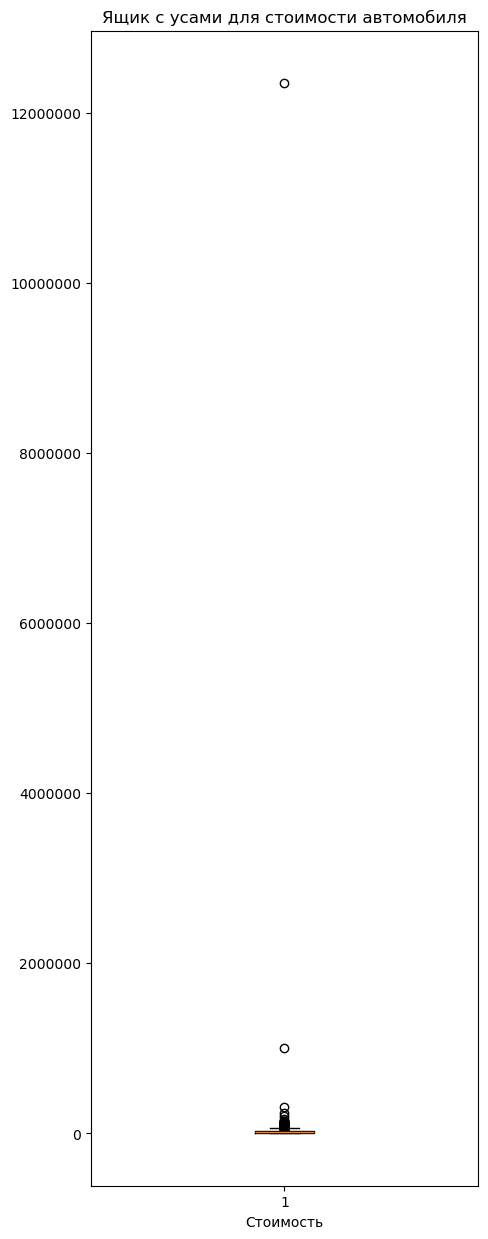

In [59]:
# Поиск аномалии в стоимости автомобиля.
# График с усами для поиска выбросов
fig, ax = plt.subplots(figsize=(5, 15))
ax.boxplot(df_year.price)
ax.set_xlabel('Стоимость')
ax.set_title('Ящик с усами для стоимости автомобиля')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Из ящик с усами можно увидеть что выбросы есть, но из-за того что они разбросаны сам ящик не виден.

In [60]:
# описательная статистика стоимости
df_year.price.describe().apply(lambda x: f"{x:0.3f}") 

count        9825.000
mean        20621.329
std        125709.226
min           500.000
25%          7800.000
50%         15590.000
75%         27990.000
max      12345678.000
Name: price, dtype: object

In [61]:
#Границы для нормальных значении стоимости 
year_boundries = calculate_outliers(df_year['price'])
year_boundries                   

(-22485.0, 58275.0)

In [62]:
outliers_below = df_year[df_year['price'] < year_boundries[0]].count()[0]
outliers_above = df_year[df_year['price'] > year_boundries[1]].count()[0]
print(f"Количество выбросов ниже нижней границы: {outliers_below}")
print(f"Количество выбросов выше верхней границы: {outliers_above}")

Количество выбросов ниже нижней границы: 0
Количество выбросов выше верхней границы: 206


C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\3608189904.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  outliers_below = df_year[df_year['price'] < year_boundries[0]].count()[0]
C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\3608189904.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  outliers_above = df_year[df_year['price'] > year_boundries[1]].count()[0]


Выбросов ниже нижней границы нет. Но есть 206 выбросов выше верхней границы. Это является аномалией в стоимости.

In [63]:
above_outliers = df_year[df_year['price'] > year_boundries[1]]
above_outliers.sort_values('price').tail(15)

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,description,state,lat,long,posting_date,price_category,date,series,transmission_series,title_status_series
4133,7311841843,https://albuquerque.craigslist.org/ctd/d/albuq...,albuquerque,https://albuquerque.craigslist.org,120000,2021,chevrolet,corvette c8 z51,gas,10,...,New arrival Z51 Call or text annamarie for d...,nm,35.081800,-106.648200,2021-04-24T08:38:45-0600,high,2021-04-24 14:38:45+00:00,gas,automatic,clean
1699,7303398175,https://pullman.craigslist.org/cto/d/pullman-6...,pullman / moscow,https://pullman.craigslist.org,123456,1994,other,cadvwrambuick,gas,283466,...,I have several cars to get rid of: A '65 Ramb...,id,46.735200,-117.172900,2021-04-07T15:57:23-0700,high,2021-04-07 22:57:23+00:00,gas,other,missing
9194,7308732637,https://evansville.craigslist.org/ctd/d/evansv...,evansville,https://evansville.craigslist.org,123456,2006,jeep,wrangler,gas,12345,...,Very Nice TJ jeeps and a few LJ jeep wranglers...,in,38.025845,-87.596457,2021-04-18T09:55:42-0500,high,2021-04-18 14:55:42+00:00,gas,other,clean
3006,7308463617,https://jacksonville.craigslist.org/cto/d/pont...,jacksonville,https://jacksonville.craigslist.org,129000,2018,mercedes-benz,benz amg gt c,gas,4000,...,Beautiful car in perfect condition. Very rare ...,fl,30.122300,-81.362700,2021-04-17T16:48:42-0400,high,2021-04-17 20:48:42+00:00,gas,automatic,clean
5149,7314445453,https://boston.craigslist.org/gbs/ctd/d/methue...,boston,https://boston.craigslist.org,129995,2007,ferrari,f430 spider,gas,12351,...,2007 Ferrari F430 Spider 2dr Convertible O...,ma,42.756205,-71.210258,2021-04-29T14:45:08-0400,high,2021-04-29 18:45:08+00:00,gas,manual,clean
6566,7312384300,https://orlando.craigslist.org/ctd/d/orlando-2...,orlando,https://orlando.craigslist.org,129999,2018,mercedes-benz,maybach s560,gas,6000,...,"Serious/ready buyers, please call or text @ (4...",fl,28.463700,-81.394800,2021-04-25T12:58:01-0400,high,2021-04-25 16:58:01+00:00,gas,automatic,clean
9024,7314817013,https://sandiego.craigslist.org/csd/ctd/d/dall...,san diego,https://sandiego.craigslist.org,139950,2017,other,Mclaren 570GT W/ Upgrades,gas,13000,...,SPECIALTYEXOTICS.COMCALL/TXT 469-215-1902FREE ...,ca,32.790400,-96.804400,2021-04-30T08:20:20-0700,high,2021-04-30 15:20:20+00:00,gas,automatic,clean
4245,7316319465,https://portland.craigslist.org/clc/ctd/d/glad...,portland,https://portland.craigslist.org,149990,2015,mercedes-benz,sprinter 3500 airs,diesel,49291,...,2015 Mercedes-Benz Sprinter 3500 Airstream Int...,or,45.382346,-122.605132,2021-05-03T11:04:09-0700,high,2021-05-03 18:04:09+00:00,diesel,automatic,clean
8840,7313664504,https://austin.craigslist.org/cto/d/austin-sup...,austin,https://austin.craigslist.org,150000,2006,other,Peterbilt 378,diesel,1234,...,Selling a Wonderful Super Dump! 2006 Peterbilt...,tx,30.364900,-97.682700,2021-04-27T21:01:28-0500,high,2021-04-28 02:01:28+00:00,diesel,manual,clean
9164,7306718413,https://desmoines.craigslist.org/ctd/d/portlan...,des moines,https://desmoines.craigslist.org,163540,2020,mercedes-benz,other,other,6318,...,2020 *** Mercedes-Benz G-Class G63 AMG*** ...,ia,45.494265,-122.579192,2021-04-14T11:26:24-0500,high,2021-04-14 16:26:24+00:00,other,automatic,clean


In [64]:
# удаляем выбросы в стоимости автомобиля
df_new = df_year.copy()
df_new = df_new[~((df_new['price'] < year_boundries[0]) | (df_new['price'] > year_boundries[1]))]
df_new.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,description,state,lat,long,posting_date,price_category,date,series,transmission_series,title_status_series
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00,diesel,other,clean
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,other,automatic,clean
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,gas,other,clean
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00,gas,automatic,clean
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,gas,automatic,clean


In [65]:
df_new.shape

(9619, 23)

#### Зависимости значении

In [66]:
# Зависимость стоимости автомобиля от года производства
df_yp = df_new.groupby('year')['price'].mean().reset_index()
df_yp.rename(columns={'price': 'avg_price'}, inplace=True)
df_yp

,year,avg_price
0,1994,13536.187013
1,1995,9610.060606
2,1996,9362.960000
3,1997,6441.250000
4,1998,6528.672727
5,1999,7446.641975
6,2000,7614.410256
7,2001,7883.933884
8,2002,7173.798658
9,2003,7767.962162


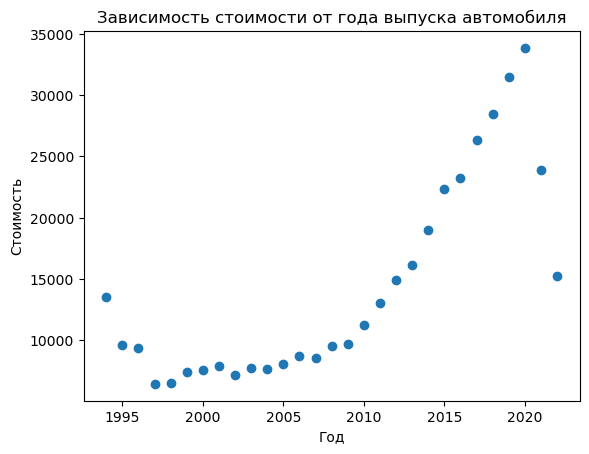

In [67]:
plt.scatter(df_yp['year'], df_yp['avg_price'])
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.title('Зависимость стоимости от года выпуска автомобиля')
plt.show()

Из графика можно сделать вывод о возрастающем тренде: чем новее автомобиль, тем выше его цена. Исключение составляют наиболее старые и самые новые автомобили. 

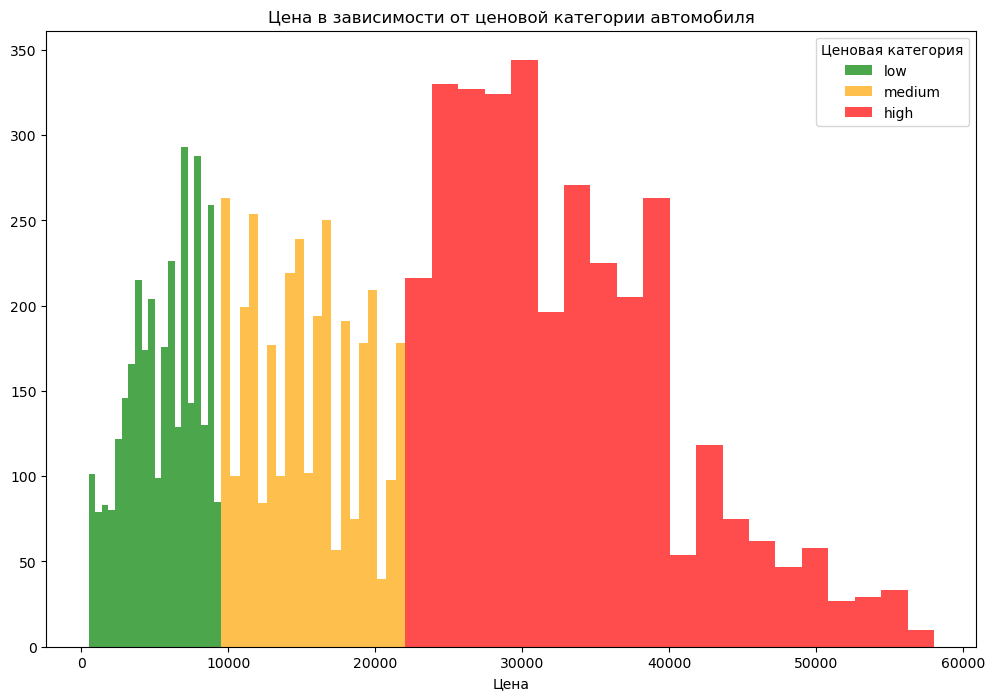

In [68]:
# Зависимость ценовой категории автомобилиля от стоимости и года производства
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}

fig, ax = plt.subplots(figsize=(12, 8))
for price_category in colors:
    color = colors[price_category]
    data = df_new[df_new['price_category'] == price_category]

    ax.hist(data['price'], bins=20, color=color, alpha=0.7)

plt.ylabel('')
plt.xlabel('Цена')
plt.title('Цена в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

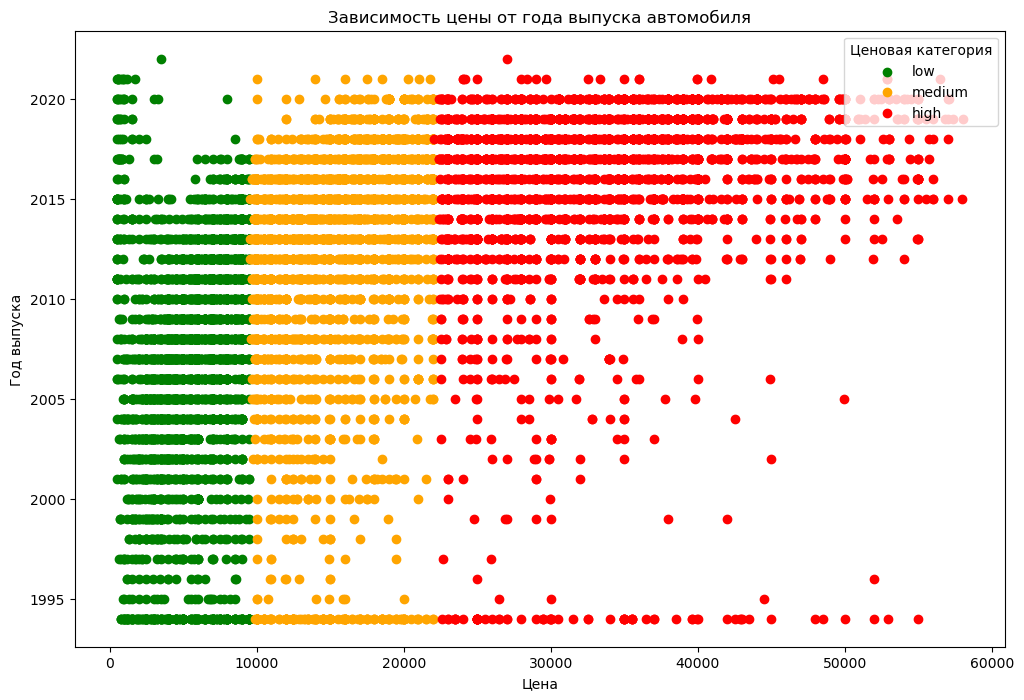

In [69]:
# Зависимость цены от года выпуска автомобиля и ценовая категория украшенная разными цветами.
# Зеленый - низкая цена
# Оранжевый - средняя цена
# Красный - высокая цена
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(12, 8))
for price_category in colors:
    color = colors[price_category]
    data = df_new[df_new['price_category'] == price_category]

    ax.scatter(data['price'], data['year'], c=color, label=price_category)

ax.legend(loc='upper right', title="Ценовая категория")
plt.title("Зависимость цены от года выпуска автомобиля")
plt.xlabel('Цена')
plt.ylabel('Год выпуска')
plt.show()

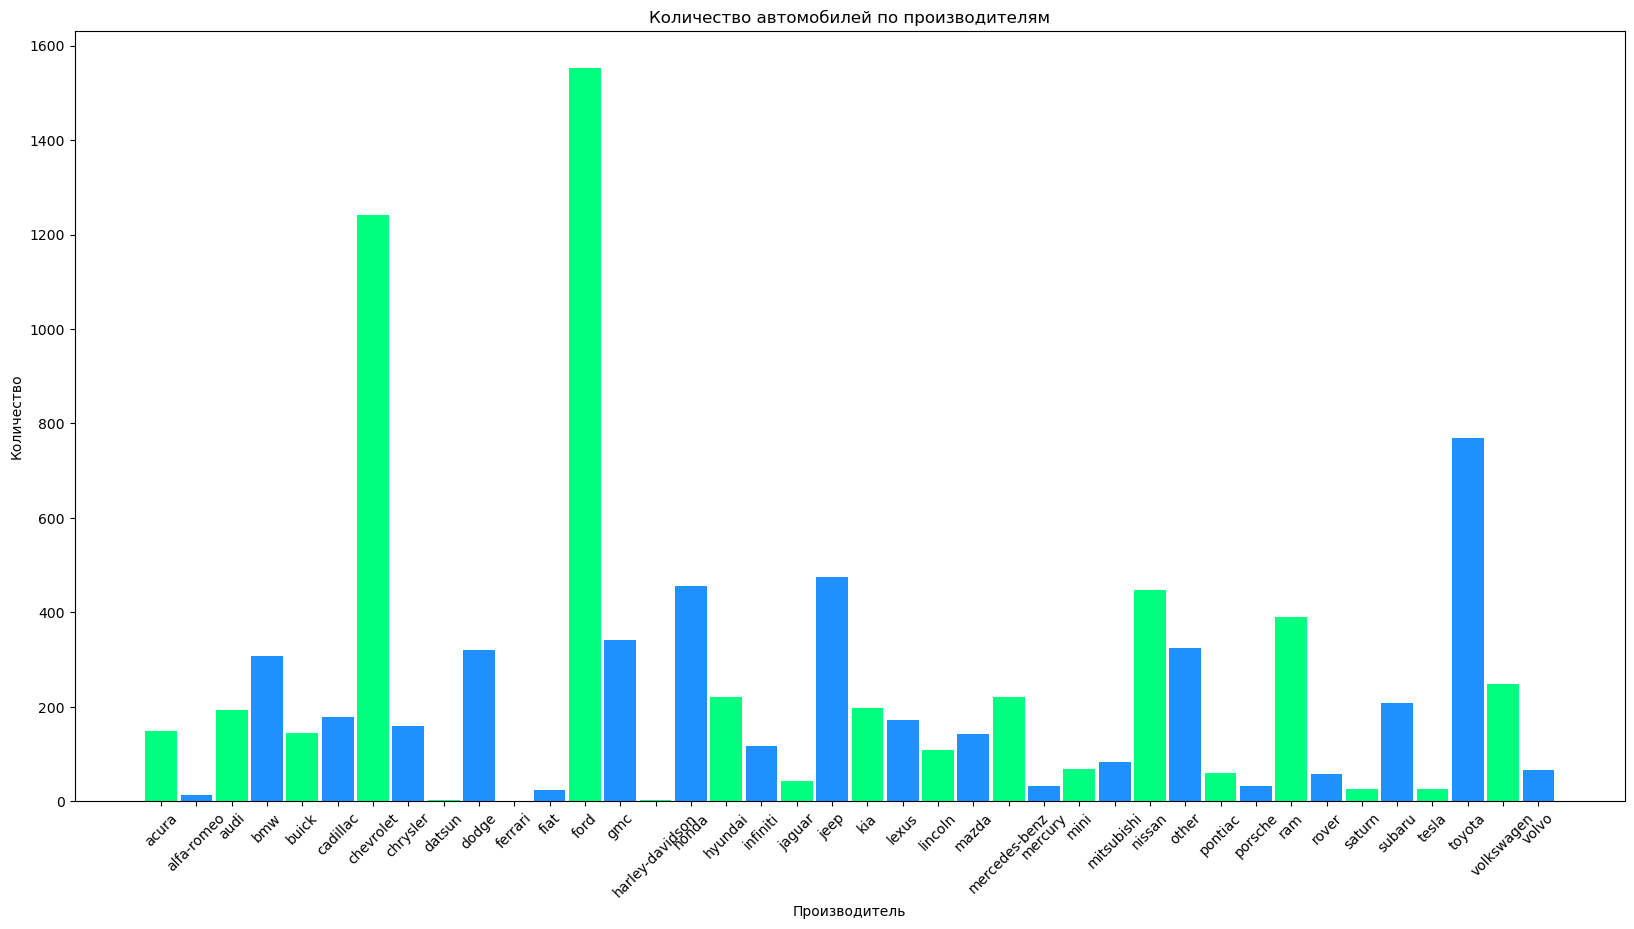

In [70]:
# Визуализация категориальных перменных

#Количество автомобилей по производителям
df_manufacturer = df_new.groupby('manufacturer')['id'].count().reset_index()
df_manufacturer.rename(columns={'id': 'count'}, inplace=True)
df_manufacturer


colors = ['springgreen', 'dodgerblue']
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(df_manufacturer['manufacturer'], df_manufacturer['count'], width=0.9, color=colors)
xticks(df_manufacturer['manufacturer'], rotation=45)
plt.title('Количество автомобилей по производителям')
plt.xlabel('Производитель')
plt.ylabel('Количество')
plt.show()

(-1.0999999704574204,
 1.099999912000936,
 -1.0999999137945349,
 1.0999999958949778)

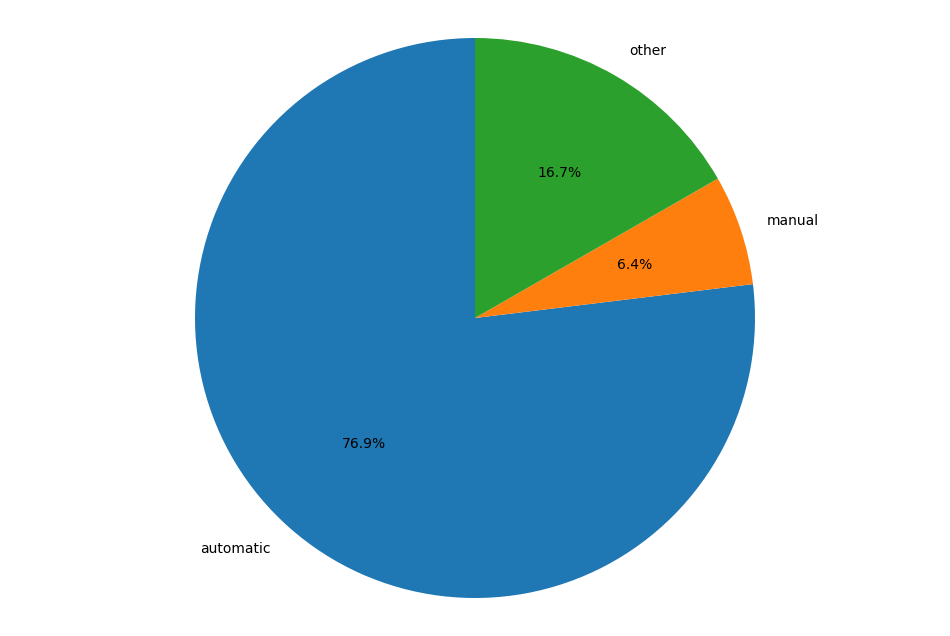

In [71]:
#Соотношение видов коробки передач
df_transmission = df_new.groupby('transmission')['id'].count().reset_index()
df_transmission.rename(columns={'id': 'count'}, inplace=True)
df_transmission

fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(df_transmission['count'], labels=df_transmission['transmission'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')

In [72]:
#
df_new.corr

<bound method DataFrame.corr of               id                                                url  \
0     7308295377  https://chattanooga.craigslist.org/ctd/d/chatt...   
1     7316380095  https://newjersey.craigslist.org/ctd/d/carlsta...   
2     7313733749  https://reno.craigslist.org/ctd/d/atlanta-2017...   
3     7308210929  https://fayetteville.craigslist.org/ctd/d/rale...   
4     7316474668  https://newyork.craigslist.org/lgi/cto/d/baldw...   
...          ...                                                ...   
9995  7304876387  https://chautauqua.craigslist.org/ctd/d/falcon...   
9996  7316152972  https://binghamton.craigslist.org/ctd/d/roches...   
9997  7310993818  https://salem.craigslist.org/ctd/d/salem-2011-...   
9998  7306637427  https://madison.craigslist.org/ctd/d/madison-2...   
9999  7311960763  https://norfolk.craigslist.org/ctd/d/chesapeak...   

                       region                           region_url  price  \
0                 chattanooga   https:

## Feature engineering

In [73]:
df_new.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'price_category', 'date', 'series', 'transmission_series',
       'title_status_series'],
      dtype='object')

In [74]:
df_new

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,description,state,lat,long,posting_date,price_category,date,series,transmission_series,title_status_series
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00,diesel,other,clean
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,other,automatic,clean
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,gas,other,clean
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00,gas,automatic,clean
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,gas,automatic,clean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002,toyota,rav4,gas,150000,...,Transmission:Automatic Exterior Color:WHITE In...,ny,42.123900,-79.189500,2021-04-10T16:33:57-0400,low,2021-04-10 20:33:57+00:00,gas,automatic,clean
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008,jeep,wrangler,gas,113573,...,2008 Jeep Wrangler X Offered by: R&L Auto -- ...,ny,43.216990,-77.755610,2021-05-03T09:36:30-0400,medium,2021-05-03 13:36:30+00:00,gas,other,clean
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011,audi,a3 2.0t premium plus pzev,gas,150184,...,2011 Audi A3 2.0T Premium Plus PZEV Wagon2011 ...,or,44.925908,-122.982753,2021-04-22T12:14:01-0700,low,2021-04-22 19:14:01+00:00,gas,automatic,clean
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015,porsche,cayenne,hybrid,61943,...,"2015 Porsche Cayenne AWD 4dr S E-Hybrid - $31,...",wi,43.029559,-89.397796,2021-04-14T09:14:42-0500,high,2021-04-14 14:14:42+00:00,hybrid,automatic,clean


### новые признаки на основе информации в датафрейме

In [75]:
df_new.odometer.describe()

count      9619.000000
mean      94813.130367
std       62973.651398
min           0.000000
25%       40364.000000
50%       90647.000000
75%      138562.000000
max      283466.000000
Name: odometer, dtype: float64

In [76]:
# создание нового столбца с значением количество пройденных миль в километрах
df_new['odometer_km'] = df.apply(lambda x: x.odometer  * 1.609344, axis=1)

In [77]:
# создание нового признака, зависимость количество пройденных миль к цене автомобиля
df_new['odometer/price'] = df.apply(lambda x: x.odometer / x.price, axis=1)
df_new['odometer/price']

0        0.499036
1        3.542852
2        0.394718
3        8.089034
4        0.366972
          ...    
9995    33.370412
9996     7.835323
9997    16.696387
9998     1.941787
9999     1.122882
Name: odometer/price, Length: 9619, dtype: float64

In [78]:
# создание признака регион которые получен из переменной region_url
df_new['region_new'] = df_new.region_url.apply(lambda x: x.lower().split('://')[1].split('.')[0])
df_new['region_new']

0        chattanooga
1          newjersey
2               reno
3       fayetteville
4            newyork
            ...     
9995      chautauqua
9996      binghamton
9997           salem
9998         madison
9999         norfolk
Name: region_new, Length: 9619, dtype: object

In [79]:
# здесь можно увидеть что новый признак не точно показывает регион, поэтому попробую создать переменную регион из признака регион
df_new[df_new['region_new'] != df_new['region']]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,long,posting_date,price_category,date,series,transmission_series,title_status_series,odometer_km,odometer/price,region_new
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,other,automatic,clean,96597.654912,3.542852,newjersey
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,gas,other,clean,22608.064512,0.394718,reno
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,gas,automatic,clean,12874.752000,0.366972,newyork
6,7316793777,https://desmoines.craigslist.org/ctd/d/martens...,des moines,https://desmoines.craigslist.org,6700,2015,ford,fusion se,gas,149000,...,-93.735800,2021-05-04T11:59:42-0500,low,2021-05-04 16:59:42+00:00,gas,automatic,clean,239792.256000,22.238806,desmoines
8,7315031640,https://grandrapids.craigslist.org/ctd/d/wyomi...,grand rapids,https://grandrapids.craigslist.org,14000,2014,dodge,charger,gas,94535,...,-85.730042,2021-04-30T17:20:30-0400,medium,2021-04-30 21:20:30+00:00,gas,automatic,clean,152139.335040,6.752500,grandrapids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,7316175335,https://orangecounty.craigslist.org/cto/d/hunt...,orange county,https://orangecounty.craigslist.org,1575,1994,other,1988 Nisan,gas,120000,...,-117.980606,2021-05-03T07:19:18-0700,low,2021-05-03 14:19:18+00:00,gas,manual,clean,193121.280000,76.190476,orangecounty
9992,7306374320,https://cnj.craigslist.org/ctd/d/trenton-2000-...,central NJ,https://cnj.craigslist.org,3000,2000,lincoln,ls,gas,161969,...,-74.663384,2021-04-13T17:01:41-0400,low,2021-04-13 21:01:41+00:00,gas,automatic,clean,260663.838336,53.989667,cnj
9993,7315504125,https://appleton.craigslist.org/ctd/d/fond-du-...,appleton-oshkosh-FDL,https://appleton.craigslist.org,8999,2013,dodge,grand caravan,gas,114730,...,-88.446483,2021-05-01T16:01:36-0500,low,2021-05-01 21:01:36+00:00,gas,automatic,clean,184640.037120,12.749194,appleton
9994,7305898015,https://fayar.craigslist.org/ctd/d/lowell-2015...,fayetteville,https://fayar.craigslist.org,22900,2015,ram,1500,diesel,151942,...,-94.130800,2021-04-12T17:15:35-0500,high,2021-04-12 22:15:35+00:00,diesel,automatic,clean,244526.946048,6.635022,fayar


In [80]:
# создание переменной region_corrected который получен из значение регион
df_new['region_corrected'] = df_new['region'].apply(lambda x: x.lower().split('/')[0].replace(' ', '').replace('-', ''))
df_new['region_corrected']

0        chattanooga
1        northjersey
2               reno
3       fayetteville
4        newyorkcity
            ...     
9995      chautauqua
9996      binghamton
9997           salem
9998         madison
9999         norfolk
Name: region_corrected, Length: 9619, dtype: object

In [81]:
# теперь различии два раза меньше
df_new[df_new['region_corrected'] != df_new['region_new']]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,posting_date,price_category,date,series,transmission_series,title_status_series,odometer_km,odometer/price,region_new,region_corrected
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,other,automatic,clean,96597.654912,3.542852,newjersey,northjersey
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,gas,automatic,clean,12874.752000,0.366972,newyork,newyorkcity
10,7314964736,https://providence.craigslist.org/ctd/d/provid...,rhode island,https://providence.craigslist.org,4000,2009,mitsubishi,galant,gas,130000,...,2021-04-30T15:20:33-0400,low,2021-04-30 19:20:33+00:00,gas,automatic,clean,209214.720000,32.500000,providence,rhodeisland
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994,ford,e-series van universal by glaval designer luxu...,gas,156925,...,2021-05-04T20:22:11-0700,medium,2021-05-05 03:22:11+00:00,gas,automatic,clean,252546.307200,10.465155,seattle,seattletacoma
15,7316941744,https://honolulu.craigslist.org/oah/cto/d/hale...,hawaii,https://honolulu.craigslist.org,28500,2004,chevrolet,silverado 2500hd 4x4,diesel,113000,...,2021-05-04T11:01:47-1000,high,2021-05-04 21:01:47+00:00,diesel,automatic,clean,181855.872000,3.964912,honolulu,hawaii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9976,7303241369,https://juneau.craigslist.org/ctd/d/auke-bay-2...,southeast alaska,https://juneau.craigslist.org,14995,2016,dodge,grand caravan sxt,gas,61493,...,2021-04-07T10:18:49-0800,medium,2021-04-07 18:18:49+00:00,gas,automatic,clean,98963.390592,4.100900,juneau,southeastalaska
9987,7302701463,https://rmn.craigslist.org/ctd/d/rochester-201...,rochester,https://rmn.craigslist.org,19990,2013,volkswagen,eos sport convertible,gas,24294,...,2021-04-06T12:51:16-0500,medium,2021-04-06 17:51:16+00:00,gas,automatic,clean,39097.403136,1.215308,rmn,rochester
9992,7306374320,https://cnj.craigslist.org/ctd/d/trenton-2000-...,central NJ,https://cnj.craigslist.org,3000,2000,lincoln,ls,gas,161969,...,2021-04-13T17:01:41-0400,low,2021-04-13 21:01:41+00:00,gas,automatic,clean,260663.838336,53.989667,cnj,centralnj
9993,7315504125,https://appleton.craigslist.org/ctd/d/fond-du-...,appleton-oshkosh-FDL,https://appleton.craigslist.org,8999,2013,dodge,grand caravan,gas,114730,...,2021-05-01T16:01:36-0500,low,2021-05-01 21:01:36+00:00,gas,automatic,clean,184640.037120,12.749194,appleton,appletonoshkoshfdl


In [82]:
# создание признака модел и производитель автомобиля
df_new['manufacturer_model'] = df_new.apply(lambda x: ': '.join([x.manufacturer, x.model]), axis=1)
df_new['manufacturer_model'] 

0           ram: 2500 crew cab big horn
1            ford: explorer 4wd 4dr xlt
2          volkswagen: golf r hatchback
3                          toyota: rav4
4                        nissan: altima
                     ...               
9995                       toyota: rav4
9996                     jeep: wrangler
9997    audi: a3 2.0t premium plus pzev
9998                   porsche: cayenne
9999        ram: 1500 crew cab big horn
Name: manufacturer_model, Length: 9619, dtype: object

In [83]:
# создание признака длина описания
df_new['desc_len'] = df_new.apply(lambda x: len(x.description) , axis=1)
df_new['desc_len']

0       4482
1        968
2       4286
3       3241
4        538
        ... 
9995    1710
9996     948
9997     909
9998    3644
9999    4483
Name: desc_len, Length: 9619, dtype: int64

In [84]:
# создание признака частота модели в описании
df_new['model_in_desc'] = df_new.apply(lambda x: x.description.count(x.model) , axis=1)
df_new['model_in_desc']

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: model_in_desc, Length: 9619, dtype: int64

In [85]:
# создание переменной краткое название модели
df_new['short_model'] = df_new.apply(lambda x: x.model.split()[0], axis=1)
df_new['short_model']

0           2500
1       explorer
2           golf
3           rav4
4         altima
          ...   
9995        rav4
9996    wrangler
9997          a3
9998     cayenne
9999        1500
Name: short_model, Length: 9619, dtype: object

In [86]:
# признак price_k$, обозначающий стоимость автомобиля в тысячах долларов
df_new['price_k$'] = df.apply(lambda x: round(x.price / 1000) , axis=1)
df_new['price_k$']

0       55
1       17
2       36
3       14
4       22
        ..
9995     4
9996    14
9997     9
9998    32
9999    32
Name: price_k$, Length: 9619, dtype: int64

In [87]:
# признак age_category, обозначающий возрастную категорию автомобиля.
# три категории:
# new — автомобиль старше 2013 года выпуска;
# average— автомобиль, выпущенный между 2006 и 2013 годом;
# old — автомобиль до 2006 года выпуска.

df_new['age_category'] =  df_new.apply(lambda x: "new" if x.year > 2013 else ("old" if x.year < 2006 else "average"), axis=1)
df_new['age_category']

0           new
1           new
2           new
3       average
4           new
         ...   
9995        old
9996    average
9997    average
9998        new
9999        new
Name: age_category, Length: 9619, dtype: object

In [88]:
# признак model_len, обозначающий количество символов (длину строки) в модели автомобиля
df_new['model_len'] = df_new.apply(lambda x: len(x.model) , axis=1)
df_new['model_len']

0       22
1       20
2       16
3        4
4        6
        ..
9995     4
9996     8
9997    25
9998     7
9999    22
Name: model_len, Length: 9619, dtype: int64

In [89]:
# признак model_word_count, обозначающий количество слов в модели автомобиля
df_new['model_word_count'] = df_new.apply(lambda x: len(x.model.split(' ')), axis=1)
df_new['model_word_count']

0       5
1       4
2       3
3       1
4       1
       ..
9995    1
9996    1
9997    5
9998    1
9999    5
Name: model_word_count, Length: 9619, dtype: int64

In [90]:
# создание признака, содержащий 1, если данный автомобиль произведён именно этим производителем, и 0, если нет
manufacturer_names = ['audi', 'ford', 'chevrolet', 'toyota', 'jeep', 'honda', 'nissan']

for manufacturer in manufacturer_names:
    col_name = 'is_' + manufacturer

    df_new[col_name] = df_new.apply(lambda x: 1 if x.manufacturer == manufacturer else 0, axis=1)

### Преобразование категориальных данных

In [91]:
data = df_new[['fuel','short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']]  
data

,fuel,short_model,transmission,region,manufacturer,state,title_status,age_category
0,diesel,2500,other,chattanooga,ram,tn,clean,new
1,other,explorer,automatic,north jersey,ford,nj,clean,new
2,gas,golf,other,reno / tahoe,volkswagen,ca,clean,new
3,gas,rav4,automatic,fayetteville,toyota,nc,clean,average
4,gas,altima,automatic,new york city,nissan,ny,clean,new
...,...,...,...,...,...,...,...,...
9995,gas,rav4,automatic,chautauqua,toyota,ny,clean,old
9996,gas,wrangler,other,binghamton,jeep,ny,clean,average
9997,gas,a3,automatic,salem,audi,or,clean,average
9998,hybrid,cayenne,automatic,madison,porsche,wi,clean,new


In [92]:
# объект класса OneHotEncoder, который будет отвечать за преобразование
ohe = OneHotEncoder(sparse=False)
ohe

OneHotEncoder(sparse=False)

In [93]:
# Идентификация параметров преобразования на датафрейме с категориальными переменными.
ohe.fit(data[['fuel','short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']])

C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [94]:
# Применить преобразование для датафрейма
ohe_category = ohe.transform(data[['fuel','short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']])
ohe_category.shape
ohe_category

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [95]:
# новые наименования признаков
ohe.get_feature_names_out()

array(['fuel_diesel', 'fuel_electric', 'fuel_gas', ...,
       'age_category_average', 'age_category_new', 'age_category_old'],
      dtype=object)

In [96]:
# Добавить в исходный датафрейм получившиеся новые признаки
df_new[ohe.get_feature_names_out()] = ohe_category
df_new.head()
df_new.columns

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\3127834323.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[ohe.get_feature_names_out()] = ohe_category
C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\3127834323.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[ohe.get_feature_names_out()] = ohe_category
C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\3127834323.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer',
       ...
       'state_wy', 'title_status_clean', 'title_status_lien',
       'title_status_missing', 'title_status_parts only',
       'title_status_rebuilt', 'title_status_salvage', 'age_category_average',
       'age_category_new', 'age_category_old'],
      dtype='object', length=1491)

In [97]:
df_new.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,state_wy,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,age_category_average,age_category_new,age_category_old
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Стандартизация данных

In [98]:
# Создание датафрейма datda из количественных переменных odometer, price, lat, long, year, odometer/price, desc_len, model_in_desc, model_len, model_word_count 
data = df_new[['odometer', 'price', 'lat', 'long', 'year', 'odometer/price', 'desc_len', 'model_in_desc', 'model_len', 'model_word_count']] 
data

,odometer,price,lat,long,year,odometer/price,desc_len,model_in_desc,model_len,model_word_count
0,27442,54990,35.060000,-85.250000,2020,0.499036,4482,0,22,5
1,60023,16942,40.821805,-74.061962,2016,3.542852,968,0,20,4
2,14048,35590,33.779214,-84.411811,2017,0.394718,4286,0,16,3
3,117291,14500,35.715954,-78.655304,2013,8.089034,3241,0,4,1
4,8000,21800,40.654800,-73.609700,2021,0.366972,538,0,6,1
...,...,...,...,...,...,...,...,...,...,...
9995,150000,4495,42.123900,-79.189500,2002,33.370412,1710,0,4,1
9996,113573,14495,43.216990,-77.755610,2008,7.835323,948,0,8,1
9997,150184,8995,44.925908,-122.982753,2011,16.696387,909,0,25,5
9998,61943,31900,43.029559,-89.397796,2015,1.941787,3644,0,7,1


In [99]:
# Создание объект std_scaler класса StandardScaler с параметрами по умолчанию, который будет отвечать за стандартизацию.
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [100]:
# Идентификация параметров преобразования на датафрейме с количественными переменными.
std_scaler.fit(data[['odometer', 'price', 'lat', 'long', 'year', 'odometer/price', 'desc_len', 'model_in_desc', 'model_len', 'model_word_count']]) 

StandardScaler()

In [101]:
# Применение преобразование для датафрейма с количественными переменными.
std_scaled = std_scaler.transform(data[['odometer', 'price', 'lat', 'long', 'year', 'odometer/price', 'desc_len', 'model_in_desc', 'model_len', 'model_word_count']])
std_scaled.shape
std_scaled

array([[-1.06988607,  2.94511697, -0.61913124, ..., -0.15475101,
         1.16112524,  1.90886091],
       [-0.55248407, -0.08845862,  0.38813237, ..., -0.15475101,
         0.93009151,  1.23368779],
       [-1.28258926,  1.39835061, -0.84303488, ..., -0.15475101,
         0.46802404,  0.55851466],
       ...,
       [ 0.87931614, -0.72207472,  1.10560087, ..., -0.15475101,
         1.50767583,  1.90886091],
       [-0.52199354,  1.10414608,  0.77408612, ..., -0.15475101,
        -0.57162774, -0.79183158],
       [-0.93523546,  1.1113218 , -0.33767527, ..., -0.15475101,
         1.16112524,  1.90886091]])

In [102]:
# Создание наименования новых признаков и добавление их в исходный датафрейм
df_new[['odometer_std', 'price_std','lat_std', 'long_std', 'year_std', 'odometer/price_std', 'desc_len_std', 'model_in_desc_std', 'model_len_std', 'model_word_count_std']] = std_scaled
df_new

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\2876424776.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[['odometer_std', 'price_std','lat_std', 'long_std', 'year_std', 'odometer/price_std', 'desc_len_std', 'model_in_desc_std', 'model_len_std', 'model_word_count_std']] = std_scaled
C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\2876424776.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[['odometer_std', 'price_std','lat_std', 'long_std', 'year_std', 'odometer/price_std', 'desc_len_std', 'model_in_de

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,odometer_std,price_std,lat_std,long_std,year_std,odometer/price_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,-1.069886,2.945117,-0.619131,0.486205,1.297206,-0.508754,0.626231,-0.154751,1.161125,1.908861
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,-0.552484,-0.088459,0.388132,1.112533,0.683042,-0.401271,-0.645479,-0.154751,0.930092,1.233688
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,-1.282589,1.398351,-0.843035,0.533129,0.836583,-0.512438,0.555299,-0.154751,0.468024,0.558515
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.356959,-0.283160,-0.504459,0.855389,0.222418,-0.240737,0.177115,-0.154751,-0.918178,-0.791832
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,-1.378634,0.298871,0.358937,1.137852,1.450747,-0.513417,-0.801095,-0.154751,-0.687145,-0.791832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002,toyota,rav4,gas,150000,...,0.876394,-1.080861,0.615761,0.825484,-1.466534,0.651996,-0.376951,-0.154751,-0.918178,-0.791832
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008,jeep,wrangler,gas,113573,...,0.297916,-0.283558,0.806852,0.905756,-0.545287,-0.249696,-0.652717,-0.154751,-0.456111,-0.791832
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011,audi,a3 2.0t premium plus pzev,gas,150184,...,0.879316,-0.722075,1.105601,-1.626147,-0.084664,0.063205,-0.666831,-0.154751,1.507676,1.908861
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015,porsche,cayenne,hybrid,61943,...,-0.521994,1.104146,0.774086,0.254004,0.529500,-0.457808,0.322960,-0.154751,-0.571628,-0.791832


In [103]:
# датафрейм, содержащий переменные lat и long.
df_latlong = df_new[['lat', 'long']]
df_latlong

,lat,long
0,35.060000,-85.250000
1,40.821805,-74.061962
2,33.779214,-84.411811
3,35.715954,-78.655304
4,40.654800,-73.609700
...,...,...
9995,42.123900,-79.189500
9996,43.216990,-77.755610
9997,44.925908,-122.982753
9998,43.029559,-89.397796


In [104]:
# добавления в исходный датафрейм признаков lat_mm и long_mm
mm_scaler = MinMaxScaler()
mm_scaler.fit(df_latlong[['lat', 'long']])
mm_scaled = mm_scaler.transform(df_latlong[['lat', 'long']])
df_new[['lat_mm', 'long_mm']] = mm_scaled
df_new.head()

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\2906530842.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[['lat_mm', 'long_mm']] = mm_scaled
C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\2906530842.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[['lat_mm', 'long_mm']] = mm_scaled


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,lat_std,long_std,year_std,odometer/price_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,lat_mm,long_mm
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,-0.619131,0.486205,1.297206,-0.508754,0.626231,-0.154751,1.161125,1.908861,0.341769,0.288699
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.388132,1.112533,0.683042,-0.401271,-0.645479,-0.154751,0.930092,1.233688,0.468665,0.333055
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,-0.843035,0.533129,0.836583,-0.512438,0.555299,-0.154751,0.468024,0.558515,0.313561,0.292022
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,-0.504459,0.855389,0.222418,-0.240737,0.177115,-0.154751,-0.918178,-0.791832,0.356215,0.314844
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.358937,1.137852,1.450747,-0.513417,-0.801095,-0.154751,-0.687145,-0.791832,0.464987,0.334848


In [105]:
df_new.date

0       2021-04-17 16:30:50+00:00
1       2021-05-03 19:40:21+00:00
2       2021-04-28 10:52:20+00:00
3       2021-04-17 14:08:57+00:00
4       2021-05-03 22:32:06+00:00
                  ...            
9995    2021-04-10 20:33:57+00:00
9996    2021-05-03 13:36:30+00:00
9997    2021-04-22 19:14:01+00:00
9998    2021-04-14 14:14:42+00:00
9999    2021-04-24 17:50:49+00:00
Name: date, Length: 9619, dtype: object

In [106]:
# изменить тип date c помощью pd.to_datetime.
df_new['date'] = pd.to_datetime(df_new.date)
df_new['date']

0      2021-04-17 16:30:50+00:00
1      2021-05-03 19:40:21+00:00
2      2021-04-28 10:52:20+00:00
3      2021-04-17 14:08:57+00:00
4      2021-05-03 22:32:06+00:00
                  ...           
9995   2021-04-10 20:33:57+00:00
9996   2021-05-03 13:36:30+00:00
9997   2021-04-22 19:14:01+00:00
9998   2021-04-14 14:14:42+00:00
9999   2021-04-24 17:50:49+00:00
Name: date, Length: 9619, dtype: datetime64[ns, UTC]

In [107]:
# Создание признака month, обозначающий номер месяца размещения объявления о продаже автомобиля
df_new['month'] = df_new['date'].apply(lambda x: x.month)
df_new.month

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\222147792.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['month'] = df_new['date'].apply(lambda x: x.month)


0       4
1       5
2       4
3       4
4       5
       ..
9995    4
9996    5
9997    4
9998    4
9999    4
Name: month, Length: 9619, dtype: int64

In [108]:
# Создание признака dayofweek, обозначающий день недели размещения объявления о продаже автомобиля.
df_new['dayofweek'] = df_new['date'].apply(lambda x: x.day)
df_new

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\997681911.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['dayofweek'] = df_new['date'].apply(lambda x: x.day)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,year_std,odometer/price_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,lat_mm,long_mm,month,dayofweek
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,1.297206,-0.508754,0.626231,-0.154751,1.161125,1.908861,0.341769,0.288699,4,17
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.683042,-0.401271,-0.645479,-0.154751,0.930092,1.233688,0.468665,0.333055,5,3
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.836583,-0.512438,0.555299,-0.154751,0.468024,0.558515,0.313561,0.292022,4,28
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.222418,-0.240737,0.177115,-0.154751,-0.918178,-0.791832,0.356215,0.314844,4,17
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,1.450747,-0.513417,-0.801095,-0.154751,-0.687145,-0.791832,0.464987,0.334848,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002,toyota,rav4,gas,150000,...,-1.466534,0.651996,-0.376951,-0.154751,-0.918178,-0.791832,0.497341,0.312727,4,10
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008,jeep,wrangler,gas,113573,...,-0.545287,-0.249696,-0.652717,-0.154751,-0.456111,-0.791832,0.521415,0.318411,5,3
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011,audi,a3 2.0t premium plus pzev,gas,150184,...,-0.084664,0.063205,-0.666831,-0.154751,1.507676,1.908861,0.559052,0.139104,4,22
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015,porsche,cayenne,hybrid,61943,...,0.529500,-0.457808,0.322960,-0.154751,-0.571628,-0.791832,0.517287,0.272255,4,14


In [109]:
# признак diff_years, обозначающий количество лет между годом производства автомобиля и годом размещения объявления о продаже автомобиля
df_new['diff_years'] = df_new.apply(lambda x: int(x.posting_date.split('-')[0]) - x.year, axis=1)
df_new[['year', 'posting_date', 'diff_years']]

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\1011586000.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['diff_years'] = df_new.apply(lambda x: int(x.posting_date.split('-')[0]) - x.year, axis=1)


,year,posting_date,diff_years
0,2020,2021-04-17T12:30:50-0400,1
1,2016,2021-05-03T15:40:21-0400,5
2,2017,2021-04-28T03:52:20-0700,4
3,2013,2021-04-17T10:08:57-0400,8
4,2021,2021-05-03T18:32:06-0400,0
...,...,...,...
9995,2002,2021-04-10T16:33:57-0400,19
9996,2008,2021-05-03T09:36:30-0400,13
9997,2011,2021-04-22T12:14:01-0700,10
9998,2015,2021-04-14T09:14:42-0500,6


In [110]:
# Примение стандартизации к новым признакам
std_scaler = StandardScaler()
std_scaler.fit(df_new[['diff_years', 'dayofweek', 'month']])
std_scaled = std_scaler.transform(df_new[['diff_years', 'dayofweek', 'month']])
df_new[['diff_years_std', 'dayofweek_std', 'month_std']] = std_scaled
df_new

C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\839083437.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[['diff_years_std', 'dayofweek_std', 'month_std']] = std_scaled
C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\839083437.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[['diff_years_std', 'dayofweek_std', 'month_std']] = std_scaled
C:\Users\Huawei\AppData\Local\Temp\ipykernel_15960\839083437.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,model_len_std,model_word_count_std,lat_mm,long_mm,month,dayofweek,diff_years,diff_years_std,dayofweek_std,month_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,1.161125,1.908861,0.341769,0.288699,4,17,1,-1.297206,0.171642,-0.616649
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.930092,1.233688,0.468665,0.333055,5,3,5,-0.683042,-1.209305,1.621669
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.468024,0.558515,0.313561,0.292022,4,28,4,-0.836583,1.256671,-0.616649
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,-0.918178,-0.791832,0.356215,0.314844,4,17,8,-0.222418,0.171642,-0.616649
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,-0.687145,-0.791832,0.464987,0.334848,5,3,0,-1.450747,-1.209305,1.621669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002,toyota,rav4,gas,150000,...,-0.918178,-0.791832,0.497341,0.312727,4,10,19,1.466534,-0.518832,-0.616649
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008,jeep,wrangler,gas,113573,...,-0.456111,-0.791832,0.521415,0.318411,5,3,13,0.545287,-1.209305,1.621669
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011,audi,a3 2.0t premium plus pzev,gas,150184,...,1.507676,1.908861,0.559052,0.139104,4,22,10,0.084664,0.664837,-0.616649
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015,porsche,cayenne,hybrid,61943,...,-0.571628,-0.791832,0.517287,0.272255,4,14,6,-0.529500,-0.124276,-0.616649


In [148]:
# Удаление колонок, которые были исходными для формирования признаков, а также новые признаки, которые были добавлены с целью обучения.  
columns_for_drop = ['year', 'url', 'region', 'region_url', 'manufacturer',
                    'model', 'fuel', 'odometer', 'title_status', 'transmission', 'transmission_series',
                    'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
                    'odometer_km', 'odometer/price', 'region_new', 'region_corrected', 'manufacturer_model',
                    'desc_len', 'model_in_desc', 'price_k$', 'age_category', 'model_len', 'model_word_count',
                    'short_model', 'lat_mm', 'long_mm', 'date',
                    'month', 'dayofweek', 'diff_years',
                    'odometer/price_std']


df_new.drop(columns=columns_for_drop, inplace=True)

KeyError: "['year', 'url', 'region', 'region_url', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date', 'odometer_km', 'odometer/price', 'region_new', 'region_corrected', 'manufacturer_model', 'desc_len', 'model_in_desc', 'price_k$', 'age_category', 'model_len', 'model_word_count', 'short_model', 'lat_mm', 'long_mm', 'date', 'month', 'dayofweek', 'diff_years', 'odometer/price_std'] not found in axis"

In [171]:
columns_for_drop = ['title_status_series']


df_new.drop(columns=columns_for_drop, inplace=True)

In [172]:
# Оставшийся список колонок и размерность финального датафрейма.
df_new.columns  

Index(['id', 'price', 'price_category', 'is_audi', 'is_ford', 'is_chevrolet',
       'is_toyota', 'is_jeep', 'is_honda', 'is_nissan',
       ...
       'lat_std', 'long_std', 'year_std', 'desc_len_std', 'model_in_desc_std',
       'model_len_std', 'model_word_count_std', 'diff_years_std',
       'dayofweek_std', 'month_std'],
      dtype='object', length=1471)

In [173]:
df_new.shape

(9619, 1471)

In [174]:
# Сохранение датафрейма в новый датафрейм df_prepared
df_new.to_csv('data/model_dataset_prepared.csv', index=False) 

## Modeling

In [219]:
# загрузка подготовленного датасета
df_prepared = pd.read_csv('model_dataset_prepared.csv')
print(df_prepared.shape)
df_prepared.head(5)

(9619, 1471)


,id,price,price_category,is_audi,is_ford,is_chevrolet,is_toyota,is_jeep,is_honda,is_nissan,...,lat_std,long_std,year_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,diff_years_std,dayofweek_std,month_std
0,7308295377,54990,high,0,0,0,0,0,0,0,...,-0.619131,0.486205,1.297206,0.626231,-0.154751,1.161125,1.908861,-1.297206,0.171642,-0.616649
1,7316380095,16942,medium,0,1,0,0,0,0,0,...,0.388132,1.112533,0.683042,-0.645479,-0.154751,0.930092,1.233688,-0.683042,-1.209305,1.621669
2,7313733749,35590,high,0,0,0,0,0,0,0,...,-0.843035,0.533129,0.836583,0.555299,-0.154751,0.468024,0.558515,-0.836583,1.256671,-0.616649
3,7308210929,14500,medium,0,0,0,1,0,0,0,...,-0.504459,0.855389,0.222418,0.177115,-0.154751,-0.918178,-0.791832,-0.222418,0.171642,-0.616649
4,7316474668,21800,medium,0,0,0,0,0,0,1,...,0.358937,1.137852,1.450747,-0.801095,-0.154751,-0.687145,-0.791832,-1.450747,-1.209305,1.621669


In [220]:
df_prepared.info

<bound method DataFrame.info of               id  price price_category  is_audi  is_ford  is_chevrolet  \
0     7308295377  54990           high        0        0             0   
1     7316380095  16942         medium        0        1             0   
2     7313733749  35590           high        0        0             0   
3     7308210929  14500         medium        0        0             0   
4     7316474668  21800         medium        0        0             0   
...          ...    ...            ...      ...      ...           ...   
9614  7304876387   4495            low        0        0             0   
9615  7316152972  14495         medium        0        0             0   
9616  7310993818   8995            low        1        0             0   
9617  7306637427  31900           high        0        0             0   
9618  7311960763  31990           high        0        0             0   

      is_toyota  is_jeep  is_honda  is_nissan  ...   lat_std  long_std  \
0    

### Инициализация переменных

In [221]:
#инициализация фичи и целевой переменной (price_category)
x = df_prepared.drop(['price_category'], axis=1)
y = df_prepared['price_category']

In [222]:
#деление данных на треин и тест
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Три модели: логистическая регрессия, случайный лес и многослойный персептрон

In [223]:
#объявление три модели: логистическая регрессия, случайный лес и многослойный персептрон;
logreg = LogisticRegression(random_state=42, penalty=None, solver='newton-cg', max_iter=350, multi_class='auto', dual=False)

In [224]:
#
logreg.fit(x_train, y_train)
ytrain_pred_lg = logreg.predict(x_train)
print(f'Точность модели train lg: {accuracy_score(y_train, ytrain_pred_lg)}')

C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Точность модели train lg: 0.999108866775583


C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [225]:
#
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
ytrain_pred_rf = rf.predict(x_train)
print(f'Точность модели train rf: {accuracy_score(y_train, ytrain_pred_rf)}')

Точность модели train rf: 1.0


In [226]:
#
mclass = MLPClassifier(random_state=50, max_iter=1000, hidden_layer_sizes=(500,20), activation = 'tanh')
mclass.fit(x_train, y_train)
ytrain_pred_mclass = mclass.predict(x_train)
print(f'Точность модели mclass: {accuracy_score(y_train, ytrain_pred_mclass)}')

Точность модели mclass: 0.3329867815238378


### Кросс-валидация

In [227]:
# кросс-валидация на тренировочной выборке
for model in [logreg, rf, mclass]:
  cv_score = cross_val_score(model, x, y, cv=5)
  print(cv_score.mean(), cv_score.std())

C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\

0.9995841995841996 0.0006061280555972084
0.9992723492723492 0.0007778913486016303
0.33361058766674995 0.0006159737844905342


In [228]:
# по результатам кросс валидации лучшая модель выявилась логистическая регрессия
# обучаем модель на тестовой выборке
logreg_pred_test = logreg.predict(x_test)

print('Точность тестовых данных на логистической регрессии:', accuracy_score(y_test, logreg_pred_test))

Точность тестовых данных на логистической регрессии: 0.9993069993069993


## Results

по результатам кросс валидации лучшая модель выявилась логистическая регрессия


In [229]:
logreg.fit(x, y)

C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Huawei\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(max_iter=350, penalty=None, random_state=42,
                   solver='newton-cg')

In [231]:
filename = 'model.pickle'

with open(filename, 'wb') as file:
  pickle.dump(logreg, file)

In [232]:
with open(filename, 'rb') as file:
  model_from_pickle = pickle.load(file)

In [233]:
model_from_pickle

LogisticRegression(max_iter=350, penalty=None, random_state=42,
                   solver='newton-cg')